## 0. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import calendar
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

import xgboost as xgb

## 1. Set Up Constants

In [2]:
TEST_SIZE = 0.2
SEQUENCE_LENGTH = 14
RANDOM_STATE_SEED = 42

RSI_ROLLING_WINDOW_SIZE = 14

XGB_TEST_SIZE = 0.3
XGB_N_ESTIMATORS = 1500
XGB_MAX_DEPTH = 10
XGB_LEARNING_RATE = 0.008
XGB_COLSAMPLE_BYTREE = 1.0
XGB_MIN_CHILD_WEIGHT = 12
XGB_SUBSAMPLE = 0.8
XGB_GAMMA = 0.15

## 2. Original S&P 500 Dataset

In [3]:
"""
Assume that today is 2nd Jan 2025 and it is before market opening in the S&P500:

 - ARIMA: I used price data from previous day (1st Jan) to predict price (2nd Jan) of today

 - GRU: I used price data from previous day (1st Jan) to predict price (2nd Jan) of today

But i need to wait for market closing of 2nd Jan 2025 to obtain the actual results of the S&P500 prices,
so that I can calculate the prediction error of both models.

With prediction errors of 1nd Jan and actual S&P 500 price of 2nd Jan, i can predict price of tomorrow (3rd Jan)

 - XGB: 
    --> Price data of yesterday (1st Jan) to predict via ARIMA and GRU
    --> Obtain prediction error by today (2nd Jan)
    --> Using both prediction error (2nd Jan) and price data (2nd Jan) to predict tomorrow (3rd Jan)
"""

'\nAssume that today is 2nd Jan 2025 and it is before market opening in the S&P500:\n\n - ARIMA: I used price data from previous day (1st Jan) to predict price (2nd Jan) of today\n\n - GRU: I used price data from previous day (1st Jan) to predict price (2nd Jan) of today\n\nBut i need to wait for market closing of 2nd Jan 2025 to obtain the actual results of the S&P500 prices,\nso that I can calculate the prediction error of both models.\n\nWith prediction errors of 1nd Jan and actual S&P 500 price of 2nd Jan, i can predict price of tomorrow (3rd Jan)\n\n - XGB: \n    --> Price data of yesterday (1st Jan) to predict via ARIMA and GRU\n    --> Obtain prediction error by today (2nd Jan)\n    --> Using both prediction error (2nd Jan) and price data (2nd Jan) to predict tomorrow (3rd Jan)\n'

#### Read Datset

In [4]:
file_name = "SP500_forMacro.csv"

folder_name = "data"

folder_path = os.path.join(os.getcwd(), folder_name)

if os.path.isdir(folder_path):
    
    dataset_file_path = os.path.join(folder_path, file_name)
    
    df = pd.read_csv(dataset_file_path, index_col=False)
    
    print(f"Dataset has been read from {dataset_file_path}.")

else:
    print(f"Folder {folder_name} is not found at {folder_path}.")

Dataset has been read from c:\Users\ADMIN\Documents\XIAMEN\Github Projects\AML-Assignment\data\SP500_forMacro.csv.


#### Processing Original SP500 Dataset to Obtain Alligned Data with Errors

In [5]:
# Fill Missing Values

df['SP500'] = df['SP500'].ffill()

In [6]:
# Set Index as Observation Date

df['observation_date'] = pd.to_datetime(df['observation_date'])

df.set_index('observation_date', inplace=True)

In [7]:
df.head()

,SP500
observation_date,
2018-04-02,2581.88
2018-04-03,2614.45
2018-04-04,2644.69
2018-04-05,2662.84
2018-04-06,2604.47


In [8]:
# Dropout first 13 days of data due to missing data from GRU features (SMI)

df = df.iloc[(RSI_ROLLING_WINDOW_SIZE-1):]

In [9]:
df.head()

,SP500
observation_date,
2018-04-19,2693.13
2018-04-20,2670.14
2018-04-23,2670.29
2018-04-24,2634.56
2018-04-25,2639.40


In [10]:
# Columns = 'SP500'
y = df['SP500']

X = df.copy(deep=True)

In [11]:
## Train test split was done to find length of test dataset which is what we need

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE_SEED, 
                                                    shuffle=False)

In [12]:
print(f"Length of X_train: {len(X_train)}")
print(f"Lenth of y_train: {len(y_train)}")

print(f"Length of X_test: {len(X_test)}")
print(f"Length of y_test: {len(y_test)}")

Length of X_train: 1501
Lenth of y_train: 1501
Length of X_test: 376
Length of y_test: 376


In [13]:
def create_sequence(X_df, y_df, seq_length):
    new_X = []

    new_y = []
    
    for i in range(0, (len(y_df) - seq_length)):

        temp_X = None

        # If it is a DataFrame, index it in 2-dimensions
        if isinstance(X_df, pd.DataFrame):
            temp_X = X_df.iloc[i:(i+seq_length), :]

        else:
            temp_X = X_df.iloc[i:(i+seq_length)]

        temp_y = y_df.iloc[i+seq_length]

        temp_X = np.squeeze(temp_X.values)

        new_X.append(temp_X.tolist())

        new_y.append(temp_y)
    
    return new_X, new_y

In [14]:
print(type(X_test))

<class 'pandas.core.frame.DataFrame'>


In [15]:
X_test.head()

,SP500
observation_date,
2024-01-19,4839.81
2024-01-22,4850.43
2024-01-23,4864.60
2024-01-24,4868.55
2024-01-25,4894.16


In [16]:
def create_sequences_with_index(X_ori, y_ori, window_size):
    X, y = [], []
    
    # Convert dataframe to numpy for faster iteration
    X_data_values = X_ori.values
    y_data_values = y_ori.values
    
    for i in range(window_size, len(X_ori)):
        # Get the sequence of features for the window
        temp_X = X_data_values[i-window_size : i]
        temp_X = np.squeeze(temp_X)

        X.append(temp_X)
        
        # Get the target value for the current day
        y.append(y_data_values[i])
        
    # Retain the index of the day being predicted
    target_index = X_ori.index[window_size:]

    X = np.array(X)
    y = np.array(y)
        
    return X, y, pd.to_datetime(target_index)

In [17]:
#X_test, y_test = create_sequence(X_test, y_test, seq_length=SEQUENCE_LENGTH)

In [18]:
X_test, y_test, date = create_sequences_with_index(X_test, y_test, 
                                                   window_size=SEQUENCE_LENGTH)

In [19]:
print(f"Number of sequences of y_test: {len(y_test)}")

print(f"Size of y_test: [{len(y_test)}, 1]")

Number of sequences of y_test: 362
Size of y_test: [362, 1]


#### Conversion into Pandas DataFrame

In [20]:
y_test_dict = {'SP500': y_test}

y_test_pd = pd.DataFrame(y_test_dict, index=date)

In [21]:
y_test_pd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 362 entries, 2024-02-08 to 2025-06-27
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SP500   362 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


In [22]:
print(y_test_pd)

                    SP500
observation_date         
2024-02-08        4997.91
2024-02-09        5026.61
2024-02-12        5021.84
2024-02-13        4953.17
2024-02-14        5000.62
...                   ...
2025-06-23        6025.17
2025-06-24        6092.18
2025-06-25        6092.16
2025-06-26        6141.02
2025-06-27        6173.07

[362 rows x 1 columns]


## 3. GRU and ARIMA Prediction Error Files

#### Read VIXCLS File (CBOE Volatility Index)

In [23]:
"""
The CBOE Volatility Index (VIX), also known as the Fear Index, 
measures expected market volatility using a portfolio of options on the S&P 500.
"""

'\nThe CBOE Volatility Index (VIX), also known as the Fear Index, \nmeasures expected market volatility using a portfolio of options on the S&P 500.\n'

In [24]:
folder_name = 'data'

vix_filename = "VIXCLS.csv"

vix_filepath = os.path.join(os.getcwd(), folder_name, vix_filename)

In [25]:
if os.path.exists(vix_filepath):
    vix_pd = pd.read_csv(vix_filepath, index_col=False)

    print(f"VIXCLS file successfully read from:\n{vix_filepath}\n")
else:
    print(f"ERROR: VIXCLS file does not exists at:\n{vix_filepath}\n")

VIXCLS file successfully read from:
c:\Users\ADMIN\Documents\XIAMEN\Github Projects\AML-Assignment\data\VIXCLS.csv



In [26]:
vix_pd['observation_date'] = pd.to_datetime(vix_pd['observation_date'])

vix_pd = vix_pd.set_index('observation_date')

In [27]:
print(vix_pd)

                  VIXCLS
observation_date        
1990-01-02         17.24
1990-01-03         18.19
1990-01-04         19.22
1990-01-05         20.11
1990-01-08         20.26
...                  ...
2025-11-06         19.50
2025-11-07         19.08
2025-11-10         17.60
2025-11-11         17.28
2025-11-12         17.51

[9357 rows x 1 columns]


In [28]:
vix_pd.isnull().sum()

VIXCLS    299
dtype: int64

In [29]:
vix_pd = vix_pd.ffill()

In [30]:
vix_pd.isnull().sum()

VIXCLS    0
dtype: int64

#### Read Saved Prediction Errors CSV

In [31]:
folder_name = 'processed_data'

gru_error_filename = "gru_error.csv"
arima_error_filename = "arima_error.csv"

gru_error_filepath = os.path.join(os.getcwd(), folder_name, gru_error_filename)
arima_error_filepath = os.path.join(os.getcwd(), folder_name, arima_error_filename)

In [32]:
if os.path.exists(gru_error_filepath):
    gru_error_pd = pd.read_csv(gru_error_filepath, index_col=False)

    print(f"GRU prediction error file successfully read from:\n{gru_error_filepath}\n")
else:
    print(f"ERROR: GRU prediction error file does not exists at:\n{gru_error_filepath}\n")

if os.path.exists(arima_error_filepath):
    arima_error_pd = pd.read_csv(arima_error_filepath, index_col=False)

    print(f"ARIMA prediction error file successfully read from:\n{arima_error_filepath}\n")
else:
    print(f"ERROR: ARIMA prediction error file does not exists at:\n{arima_error_filepath}\n")

GRU prediction error file successfully read from:
c:\Users\ADMIN\Documents\XIAMEN\Github Projects\AML-Assignment\processed_data\gru_error.csv

ARIMA prediction error file successfully read from:
c:\Users\ADMIN\Documents\XIAMEN\Github Projects\AML-Assignment\processed_data\arima_error.csv



#### Datasets Information

In [33]:
arima_error_pd.index = date

arima_error_pd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 362 entries, 2024-02-08 to 2025-06-27
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Arima Error  362 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


In [34]:
gru_error_pd.index = date

gru_error_pd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 362 entries, 2024-02-08 to 2025-06-27
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   GRU Error  362 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


In [35]:
print(arima_error_pd)

                  Arima Error
observation_date             
2024-02-08           6.932583
2024-02-09          28.984603
2024-02-12          -1.901878
2024-02-13         -69.146173
2024-02-14          40.600359
...                       ...
2025-06-23          56.168985
2025-06-24          72.116304
2025-06-25           5.898945
2025-06-26          48.858234
2025-06-27          36.365361

[362 rows x 1 columns]


In [36]:
print(gru_error_pd)

                   GRU Error
observation_date            
2024-02-08          0.513516
2024-02-09         30.852188
2024-02-12         -4.984707
2024-02-13        -64.679121
2024-02-14         51.232305
...                      ...
2025-06-23        102.401934
2025-06-24        108.375801
2025-06-25         56.831875
2025-06-26        111.999980
2025-06-27         93.060723

[362 rows x 1 columns]


## 4. Data Pre-Processing

#### Combine Both Model Prediction Errors

In [37]:
error_df = pd.concat([y_test_pd, arima_error_pd, gru_error_pd],
                     axis=1,
                     ignore_index=True)

error_df = error_df.rename({0: "SP500", 
                            1: "ARIMA Error", 
                            2: "GRU Error"},
                            axis=1)

In [38]:
error_df.head()

,SP500,ARIMA Error,GRU Error
observation_date,,,
2024-02-08,4997.91,6.932583,0.513516
2024-02-09,5026.61,28.984603,30.852188
2024-02-12,5021.84,-1.901878,-4.984707
2024-02-13,4953.17,-69.146173,-64.679121
2024-02-14,5000.62,40.600359,51.232305


In [39]:
error_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 362 entries, 2024-02-08 to 2025-06-27
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SP500        362 non-null    float64
 1   ARIMA Error  362 non-null    float64
 2   GRU Error    362 non-null    float64
dtypes: float64(3)
memory usage: 11.3 KB


In [40]:
error_df.describe()

,SP500,ARIMA Error,GRU Error
count,362.000000,362.000000,362.000000
mean,5608.810304,3.569228,32.856977
std,338.549480,59.993949,61.489857
min,4953.170000,-348.334891,-288.575273
25%,5305.050000,-19.558409,0.879233
50%,5628.620000,5.470772,33.823984
75%,5918.250000,33.879741,65.335386
max,6173.070000,469.153425,467.504492


In [41]:
error_df.isnull().sum()

SP500          0
ARIMA Error    0
GRU Error      0
dtype: int64

In [42]:
print(error_df)

                    SP500  ARIMA Error   GRU Error
observation_date                                  
2024-02-08        4997.91     6.932583    0.513516
2024-02-09        5026.61    28.984603   30.852188
2024-02-12        5021.84    -1.901878   -4.984707
2024-02-13        4953.17   -69.146173  -64.679121
2024-02-14        5000.62    40.600359   51.232305
...                   ...          ...         ...
2025-06-23        6025.17    56.168985  102.401934
2025-06-24        6092.18    72.116304  108.375801
2025-06-25        6092.16     5.898945   56.831875
2025-06-26        6141.02    48.858234  111.999980
2025-06-27        6173.07    36.365361   93.060723

[362 rows x 3 columns]


#### Concat DFF into Error DF

In [43]:
error_df = pd.concat([error_df, vix_pd],
                     axis=1)

In [44]:
error_df.isnull().sum()

SP500          8995
ARIMA Error    8995
GRU Error      8995
VIXCLS            0
dtype: int64

In [45]:
error_df.dropna(inplace=True)

In [46]:
print(error_df)

                    SP500  ARIMA Error   GRU Error  VIXCLS
observation_date                                          
2024-02-08        4997.91     6.932583    0.513516   12.79
2024-02-09        5026.61    28.984603   30.852188   12.93
2024-02-12        5021.84    -1.901878   -4.984707   13.93
2024-02-13        4953.17   -69.146173  -64.679121   15.85
2024-02-14        5000.62    40.600359   51.232305   14.38
...                   ...          ...         ...     ...
2025-06-23        6025.17    56.168985  102.401934   19.83
2025-06-24        6092.18    72.116304  108.375801   17.48
2025-06-25        6092.16     5.898945   56.831875   16.76
2025-06-26        6141.02    48.858234  111.999980   16.59
2025-06-27        6173.07    36.365361   93.060723   16.32

[362 rows x 4 columns]


#### Feature Engineering

In [47]:
## Feature Engineering of VIX data

# Log Returns
error_df['VIX_Log_Ret'] = np.log(error_df['VIXCLS'] / error_df['VIXCLS'].shift(1))

# Rolling Z-Score (20-day)
vix_mean = error_df['VIXCLS'].rolling(window=20).mean()
vix_std = error_df['VIXCLS'].rolling(window=20).std()
error_df['VIX_ZScore'] = (error_df['VIXCLS'] - vix_mean) / vix_std

# VIX Momentum (Short-term velocity)
error_df['VIX_ROC_3'] = error_df['VIXCLS'].pct_change(periods=3)

# Spike Indicator (Binary)
error_df['VIX_Spike'] = (error_df['VIX_Log_Ret'] > error_df['VIX_Log_Ret'].rolling(50).std() * 2).astype(int)

In [48]:
def week_of_month(tgtdate):

    days_this_month = calendar.mdays[tgtdate.month]

    for i in range(1, days_this_month):
        d = datetime.datetime(tgtdate.year, tgtdate.month, i)
        if d.day - d.weekday() > 0:
            startdate = d
            break

    # now we can use the modulo 7 appraoch
    return ((tgtdate - startdate).days //7 + 1) + 1

In [49]:
## Datetime Features

def datetime_feature_engineering(df):
    df.reset_index(inplace=True)

    df['Day of Month'] = df['observation_date'].dt.day

    df['Day of Week'] = df['observation_date'].dt.dayofweek

    df['Month End'] = df['observation_date'].dt.is_month_end.astype(int)

    df['Quarter End'] = df['observation_date'].dt.is_quarter_end.astype(int)

    df = df.set_index('observation_date', drop=True)

    return df

In [50]:
error_df = datetime_feature_engineering(error_df)

In [51]:
## Prediction error of previous 2 days 
error_df['ARIMA Error Lag1'] = error_df['ARIMA Error'].shift(1)
error_df['GRU Error Lag1'] = error_df['GRU Error'].shift(1)

## Rolling Statistics (Volatility of Predictions)
error_df['ARIMA Vol_10d'] = error_df['ARIMA Error'].rolling(window=10).std()
error_df['GRU Vol_10d'] = error_df['GRU Error'].rolling(window=10).std()

## Mean Error of 10 Days
error_df['ARIMA Bias_10d'] = error_df['ARIMA Error'].rolling(window=10).mean()
error_df['GRU Bias_10d'] = error_df['GRU Error'].rolling(window=10).mean()

## 10-Day Error Correlation between ARIMA and GRU
error_df['Error Corr_10d'] = error_df['ARIMA Error'].rolling(10).corr(error_df['GRU Error'])

## Absolute Difference Between Errors (Difference in direction and magnitude of models predictions)
error_df['Error Diff'] = (error_df['ARIMA Error'] - error_df['GRU Error']).abs()

In [52]:
## Volatility Ratio
# We add a tiny epsilon (1e-9) to avoid division by zero
error_df['Vol Ratio'] = error_df['ARIMA Vol_10d'] / (error_df['GRU Vol_10d'] + 1e-9)

## Gating Weight (Determines to trust ARIMA or GRU more)
# This maps the ratio to a 0-1 scale using a sigmoid function
# If ratio is 1.0, weight is 0.5 (equal trust)
error_df['Gating Weight'] = 1 / (1 + np.exp(-(error_df['Vol Ratio'] - 1)))

## Final Gated Prediction
# High vol_ratio -> More weight to GRU
# Low vol_ratio -> More weight to ARIMA
error_df['Error Hybrid Gated'] = (error_df['ARIMA Error'] * (1 - error_df['Gating Weight'])) + (error_df['GRU Error'] * error_df['Gating Weight'])


In [53]:
error_df.isnull().sum()

SP500                  0
ARIMA Error            0
GRU Error              0
VIXCLS                 0
VIX_Log_Ret            1
VIX_ZScore            19
VIX_ROC_3              3
VIX_Spike              0
Day of Month           0
Day of Week            0
Month End              0
Quarter End            0
ARIMA Error Lag1       1
GRU Error Lag1         1
ARIMA Vol_10d          9
GRU Vol_10d            9
ARIMA Bias_10d         9
GRU Bias_10d           9
Error Corr_10d         9
Error Diff             0
Vol Ratio              9
Gating Weight          9
Error Hybrid Gated     9
dtype: int64

In [54]:
# Drop rows with missing values
error_df = error_df.dropna(axis=0)

In [55]:
error_df.head()

,SP500,ARIMA Error,GRU Error,VIXCLS,VIX_Log_Ret,VIX_ZScore,VIX_ROC_3,VIX_Spike,Day of Month,Day of Week,...,GRU Error Lag1,ARIMA Vol_10d,GRU Vol_10d,ARIMA Bias_10d,GRU Bias_10d,Error Corr_10d,Error Diff,Vol Ratio,Gating Weight,Error Hybrid Gated
observation_date,,,,,,,,,,,,,,,,,,,,,
2024-03-06,5104.76,20.894956,32.553945,14.50,0.002762,0.491517,0.106026,0,6,2,...,-44.942773,41.947627,39.762695,13.332575,17.122094,0.981409,11.658989,1.054949,0.513734,26.884574
2024-03-07,5157.36,55.214054,45.677383,14.44,-0.004147,0.342762,0.070423,0,7,3,...,32.553945,31.220426,28.830154,8.267864,11.466129,0.958717,9.536671,1.082909,0.520715,50.248163
2024-03-08,5123.69,-28.434905,-29.674746,14.74,0.020563,0.656070,0.019364,0,8,4,...,45.677383,33.228178,31.474492,4.192335,8.696096,0.979324,1.239841,1.055718,0.513926,-29.072092
2024-03-11,5117.94,-9.118428,4.935117,15.22,0.032045,1.189109,0.049655,0,11,0,...,-29.674746,32.595177,31.065229,5.189826,9.841148,0.976867,14.053545,1.049250,0.512310,-1.918658
2024-03-12,5175.27,56.755667,55.469219,13.84,-0.095047,-0.587898,-0.041551,0,12,1,...,4.935117,36.466721,34.270351,10.192705,13.719826,0.982495,1.286449,1.064090,0.516017,56.091838


In [56]:
error_df.tail()

,SP500,ARIMA Error,GRU Error,VIXCLS,VIX_Log_Ret,VIX_ZScore,VIX_ROC_3,VIX_Spike,Day of Month,Day of Week,...,GRU Error Lag1,ARIMA Vol_10d,GRU Vol_10d,ARIMA Bias_10d,GRU Bias_10d,Error Corr_10d,Error Diff,Vol Ratio,Gating Weight,Error Hybrid Gated
observation_date,,,,,,,,,,,,,,,,,,,,,
2025-06-23,6025.17,56.168985,102.401934,19.83,-0.039066,0.579091,-0.015392,0,23,0,...,26.317539,39.556754,46.395213,1.636629,47.614857,0.989370,46.232948,0.852604,0.463218,77.584902
2025-06-24,6092.18,72.116304,108.375801,17.48,-0.126139,-0.867517,-0.211547,0,24,1,...,102.401934,44.585171,48.751838,5.507056,49.650637,0.984610,36.259497,0.914533,0.478646,89.471777
2025-06-25,6092.16,5.898945,56.831875,16.76,-0.042062,-1.193651,-0.187197,0,25,2,...,108.375801,44.075167,48.267399,7.466442,52.370273,0.983290,50.932930,0.913146,0.478300,30.260168
2025-06-26,6141.02,48.858234,111.999980,16.59,-0.010195,-1.173262,-0.163389,0,26,3,...,56.831875,45.854322,51.499957,10.195622,56.059311,0.982121,63.141747,0.890376,0.472621,78.700374
2025-06-27,6173.07,36.365361,93.060723,16.32,-0.016409,-1.212601,-0.066362,0,27,4,...,111.999980,37.572387,43.198913,20.460815,68.119750,0.972744,56.695362,0.869753,0.467484,62.869548


#### Dataset Correlation

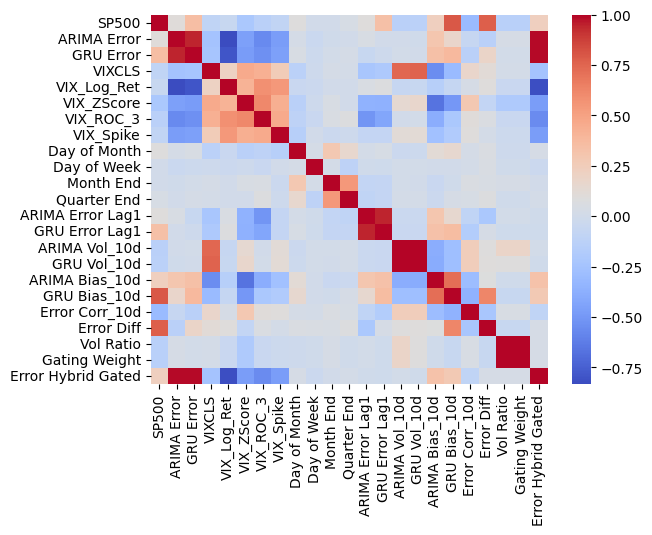

In [57]:
corr_mat = error_df.corr()

sns.heatmap(corr_mat, cmap='coolwarm')

plt.show()

#### Dataset Sequencing

In [58]:
y_xgb = error_df['SP500'].shift(-1)

y_xgb.dropna(inplace=True)

In [59]:
X_xgb = error_df.copy()

# Don't have tomorrow's data to train on the last row so drop it
X_xgb = X_xgb.iloc[:-1, :]

In [60]:
X_xgb.head()

,SP500,ARIMA Error,GRU Error,VIXCLS,VIX_Log_Ret,VIX_ZScore,VIX_ROC_3,VIX_Spike,Day of Month,Day of Week,...,GRU Error Lag1,ARIMA Vol_10d,GRU Vol_10d,ARIMA Bias_10d,GRU Bias_10d,Error Corr_10d,Error Diff,Vol Ratio,Gating Weight,Error Hybrid Gated
observation_date,,,,,,,,,,,,,,,,,,,,,
2024-03-06,5104.76,20.894956,32.553945,14.50,0.002762,0.491517,0.106026,0,6,2,...,-44.942773,41.947627,39.762695,13.332575,17.122094,0.981409,11.658989,1.054949,0.513734,26.884574
2024-03-07,5157.36,55.214054,45.677383,14.44,-0.004147,0.342762,0.070423,0,7,3,...,32.553945,31.220426,28.830154,8.267864,11.466129,0.958717,9.536671,1.082909,0.520715,50.248163
2024-03-08,5123.69,-28.434905,-29.674746,14.74,0.020563,0.656070,0.019364,0,8,4,...,45.677383,33.228178,31.474492,4.192335,8.696096,0.979324,1.239841,1.055718,0.513926,-29.072092
2024-03-11,5117.94,-9.118428,4.935117,15.22,0.032045,1.189109,0.049655,0,11,0,...,-29.674746,32.595177,31.065229,5.189826,9.841148,0.976867,14.053545,1.049250,0.512310,-1.918658
2024-03-12,5175.27,56.755667,55.469219,13.84,-0.095047,-0.587898,-0.041551,0,12,1,...,4.935117,36.466721,34.270351,10.192705,13.719826,0.982495,1.286449,1.064090,0.516017,56.091838


In [61]:
X_xgb.tail()

,SP500,ARIMA Error,GRU Error,VIXCLS,VIX_Log_Ret,VIX_ZScore,VIX_ROC_3,VIX_Spike,Day of Month,Day of Week,...,GRU Error Lag1,ARIMA Vol_10d,GRU Vol_10d,ARIMA Bias_10d,GRU Bias_10d,Error Corr_10d,Error Diff,Vol Ratio,Gating Weight,Error Hybrid Gated
observation_date,,,,,,,,,,,,,,,,,,,,,
2025-06-20,5967.84,-13.030000,26.317539,20.62,-0.072479,1.043012,-0.045370,0,20,4,...,39.842656,34.942866,42.289374,-2.892811,42.330291,0.987451,39.347539,0.826280,0.456679,4.939191
2025-06-23,6025.17,56.168985,102.401934,19.83,-0.039066,0.579091,-0.015392,0,23,0,...,26.317539,39.556754,46.395213,1.636629,47.614857,0.989370,46.232948,0.852604,0.463218,77.584902
2025-06-24,6092.18,72.116304,108.375801,17.48,-0.126139,-0.867517,-0.211547,0,24,1,...,102.401934,44.585171,48.751838,5.507056,49.650637,0.984610,36.259497,0.914533,0.478646,89.471777
2025-06-25,6092.16,5.898945,56.831875,16.76,-0.042062,-1.193651,-0.187197,0,25,2,...,108.375801,44.075167,48.267399,7.466442,52.370273,0.983290,50.932930,0.913146,0.478300,30.260168
2025-06-26,6141.02,48.858234,111.999980,16.59,-0.010195,-1.173262,-0.163389,0,26,3,...,56.831875,45.854322,51.499957,10.195622,56.059311,0.982121,63.141747,0.890376,0.472621,78.700374


In [62]:
y_xgb.head()

observation_date
2024-03-06    5157.36
2024-03-07    5123.69
2024-03-08    5117.94
2024-03-11    5175.27
2024-03-12    5165.31
Name: SP500, dtype: float64

In [63]:
print(f"Length of X: {len(X_xgb)}")
print(f"Length of y: {len(y_xgb)}")

Length of X: 342
Length of y: 342


#### Dataset Split

In [64]:
train_size = int((1 - XGB_TEST_SIZE )* len(X_xgb))

X_train = X_xgb.iloc[:train_size, :]
y_train = y_xgb.iloc[:train_size]

X_test = X_xgb.iloc[train_size:, :]
y_test = y_xgb.iloc[train_size:]

In [65]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}\n")

print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (239, 23)
Shape of y_train: (239,)

Shape of X_test: (103, 23)
Shape of y_test: (103,)


In [66]:
print(X_train)

                    SP500  ARIMA Error   GRU Error  VIXCLS  VIX_Log_Ret  \
observation_date                                                          
2024-03-06        5104.76    20.894956   32.553945   14.50     0.002762   
2024-03-07        5157.36    55.214054   45.677383   14.44    -0.004147   
2024-03-08        5123.69   -28.434905  -29.674746   14.74     0.020563   
2024-03-11        5117.94    -9.118428    4.935117   15.22     0.032045   
2024-03-12        5175.27    56.755667   55.469219   13.84    -0.095047   
...                   ...          ...         ...     ...          ...   
2025-01-28        6067.70    48.127551  117.175586   16.41    -0.086910   
2025-01-29        6039.31   -23.770243   15.248965   16.56     0.009099   
2025-01-30        6071.17    29.482092   90.273027   15.84    -0.044452   
2025-01-31        6040.53   -27.962193   12.224824   16.43     0.036571   
2025-02-03        5994.57   -48.543792    5.070000   18.62     0.125127   

                  VIX_ZS

In [67]:
print(y_train)

observation_date
2024-03-06    5157.36
2024-03-07    5123.69
2024-03-08    5117.94
2024-03-11    5175.27
2024-03-12    5165.31
               ...   
2025-01-28    6039.31
2025-01-29    6071.17
2025-01-30    6040.53
2025-01-31    5994.57
2025-02-03    6037.88
Name: SP500, Length: 239, dtype: float64


In [68]:
print(y_test[:5])

observation_date
2025-02-04    6061.48
2025-02-05    6083.57
2025-02-06    6025.99
2025-02-07    6066.44
2025-02-10    6068.50
Name: SP500, dtype: float64


In [69]:
print(X_test[:5])

                    SP500  ARIMA Error  GRU Error  VIXCLS  VIX_Log_Ret  \
observation_date                                                         
2025-02-04        6037.88    39.455633  84.125117   17.21    -0.078746   
2025-02-05        6061.48    27.256012  63.875020   15.77    -0.087381   
2025-02-06        6083.57    24.073489  74.624199   15.50    -0.017269   
2025-02-07        6025.99   -55.727518   1.702891   16.54     0.064942   
2025-02-10        6066.44    35.598549  99.953672   15.81    -0.045139   

                  VIX_ZScore  VIX_ROC_3  VIX_Spike  Day of Month  Day of Week  \
observation_date                                                                
2025-02-04          0.257195   0.086490          0             4            1   
2025-02-05         -0.663818  -0.040170          0             5            2   
2025-02-06         -0.766135  -0.167562          0             6            3   
2025-02-07          0.062348  -0.038931          0             7            

## 5. XGBoost Model

#### XGBoost Model Setup

In [70]:
xgb_model = xgb.XGBRegressor(objective = 'reg:squarederror',
                             n_estimators = XGB_N_ESTIMATORS, 
                             max_depth = XGB_MAX_DEPTH,
                             learning_rate = XGB_LEARNING_RATE,
                             colsample_bytree = XGB_COLSAMPLE_BYTREE,
                             min_child_weight = XGB_MIN_CHILD_WEIGHT,
                             subsample = XGB_SUBSAMPLE,
                             random_state = RANDOM_STATE_SEED,
                             gamma=XGB_GAMMA,
                             tree_method='hist',
                             enable_categorical=False)

#### Model Fitting

In [71]:
xgb_model.fit(X_train, y_train,
              verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.15, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.008, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=12, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1500,
             n_jobs=None, num_parallel_tree=None, ...)

#### Model Evaluation

In [72]:
## Actual = Prediction Error + Prediction

y_pred = xgb_model.predict(X_test)

print(y_pred[:5])

[6052.005  6055.688  6028.4116 6015.5176 6056.2676]


In [73]:
rmse_value = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse_value:.3f}')
print(f'R²: {r2:.4f}')

RMSE: 88.725
R²: 0.8959


#### Feature Importance

In [74]:
importance = xgb_model.get_booster().get_score(importance_type='weight')

print(type(importance))

print(importance)

<class 'dict'>
{'SP500': 2580.0, 'ARIMA Error': 627.0, 'GRU Error': 711.0, 'VIXCLS': 1299.0, 'VIX_Log_Ret': 1047.0, 'VIX_ZScore': 1337.0, 'VIX_ROC_3': 1056.0, 'Day of Month': 796.0, 'Day of Week': 297.0, 'ARIMA Error Lag1': 690.0, 'GRU Error Lag1': 670.0, 'ARIMA Vol_10d': 549.0, 'GRU Vol_10d': 588.0, 'ARIMA Bias_10d': 1076.0, 'GRU Bias_10d': 673.0, 'Error Corr_10d': 756.0, 'Error Diff': 645.0, 'Vol Ratio': 706.0, 'Error Hybrid Gated': 570.0}


In [75]:
importance_list = []

for key, val in importance.items():
    temp_pair = [key, val]

    importance_list.append(temp_pair)

importance_df = pd.DataFrame(importance_list,
                             columns=['Features', 'Importance'])

importance_df = importance_df.sort_values(by='Importance', ascending=False)

importance_df.reset_index(drop=True, inplace=True)

In [76]:
importance_df.style

,Features,Importance
0,SP500,2580.000000
1,VIX_ZScore,1337.000000
2,VIXCLS,1299.000000
3,ARIMA Bias_10d,1076.000000
4,VIX_ROC_3,1056.000000
5,VIX_Log_Ret,1047.000000
6,Day of Month,796.000000
7,Error Corr_10d,756.000000
8,GRU Error,711.000000
9,Vol Ratio,706.000000


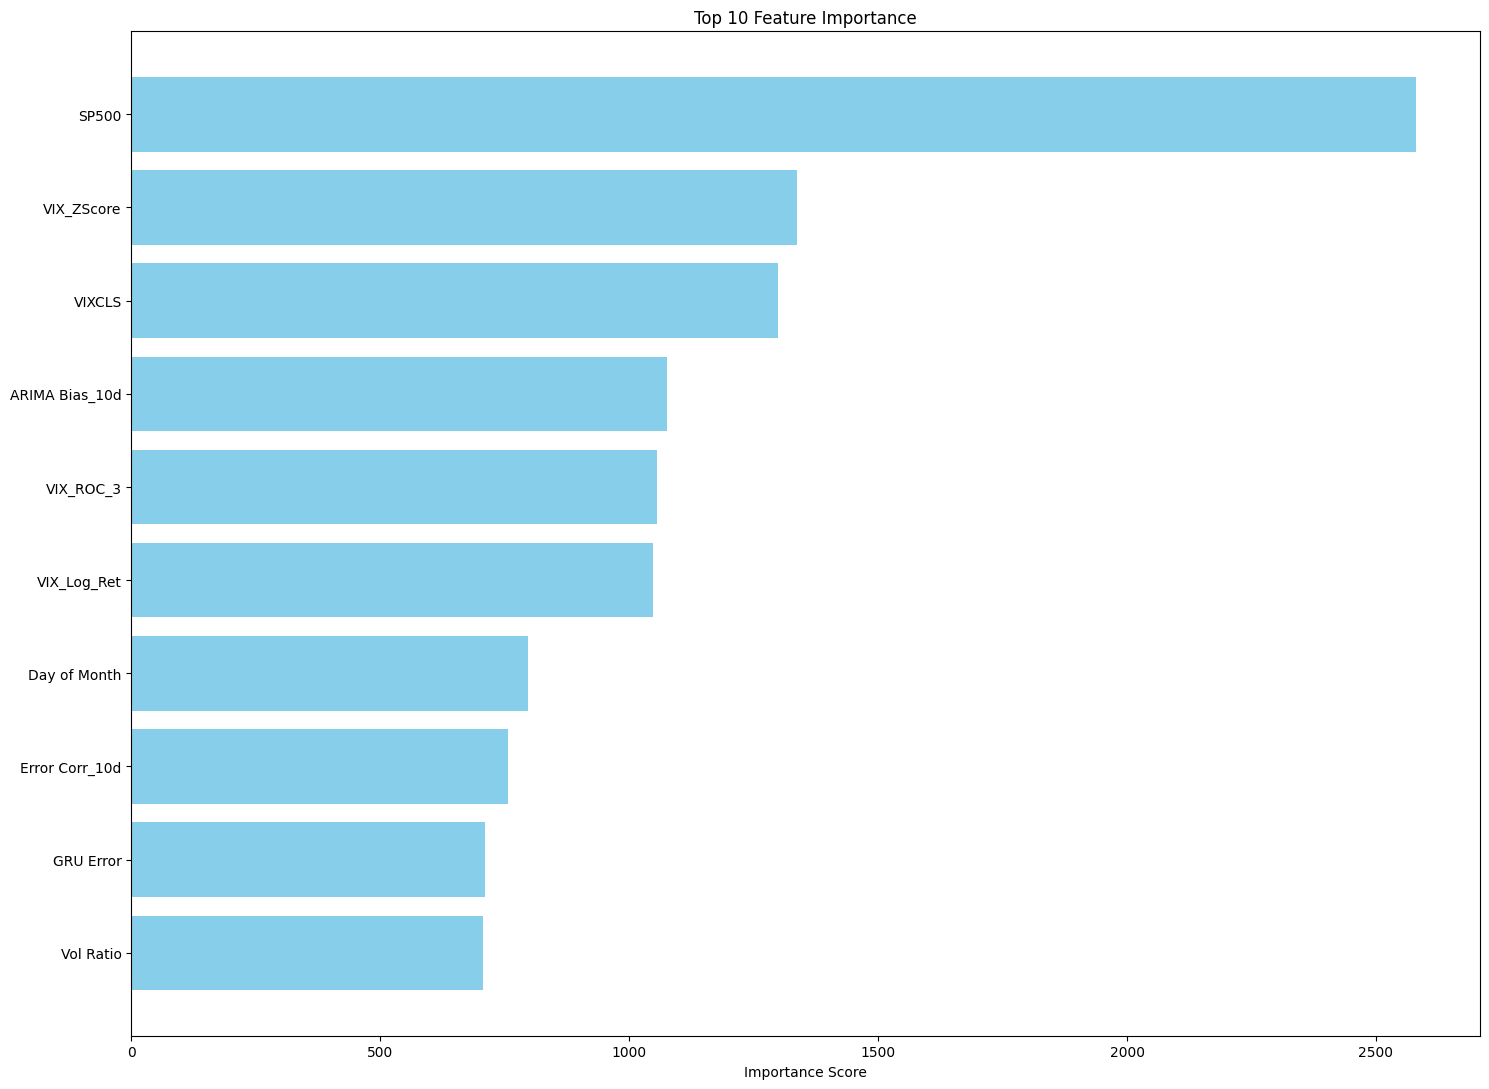

In [77]:
top_n = 10
plt.figure(figsize=(15, 11))
plt.barh(
    importance_df['Features'].head(top_n)[::-1],
    importance_df['Importance'].head(top_n)[::-1],
    color='skyblue'
)
plt.xlabel('Importance Score')
plt.title(f'Top {top_n} Feature Importance')
plt.tight_layout()
plt.show()

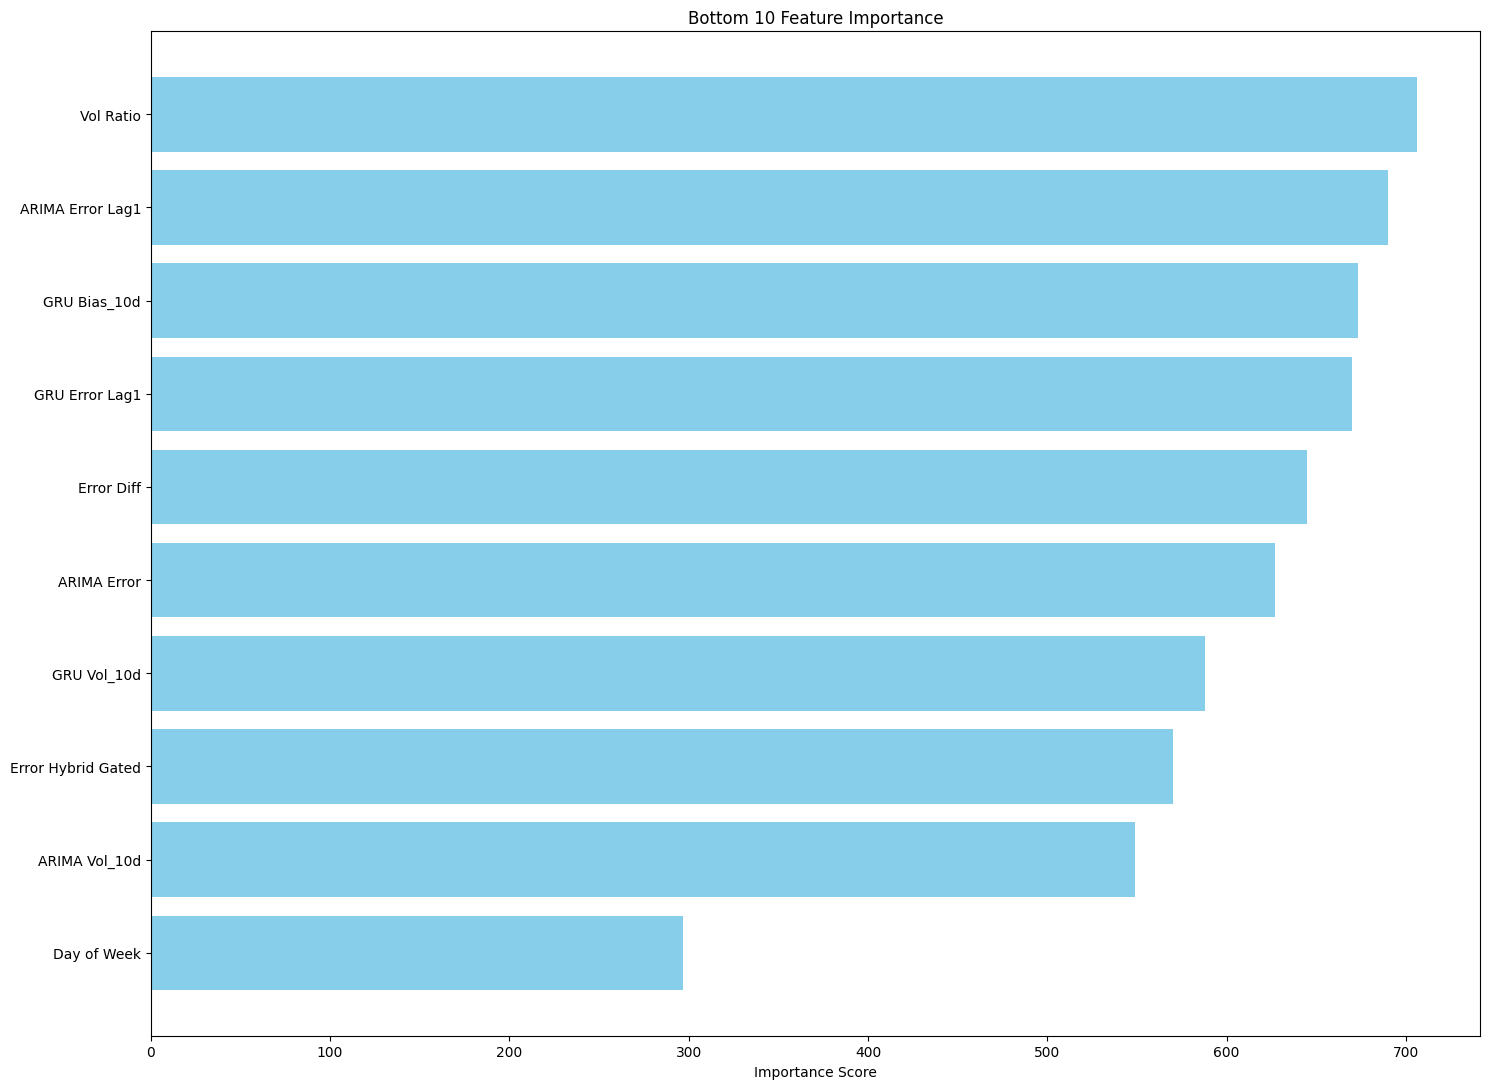

In [78]:
bottom_n = 10
plt.figure(figsize=(15, 11))
plt.barh(
    importance_df['Features'].tail(bottom_n)[::-1],
    importance_df['Importance'].tail(bottom_n)[::-1],
    color='skyblue'
)
plt.xlabel('Importance Score')
plt.title(f'Bottom {bottom_n} Feature Importance')
plt.tight_layout()
plt.show()

#### Graph of Actual vs Prediction Values

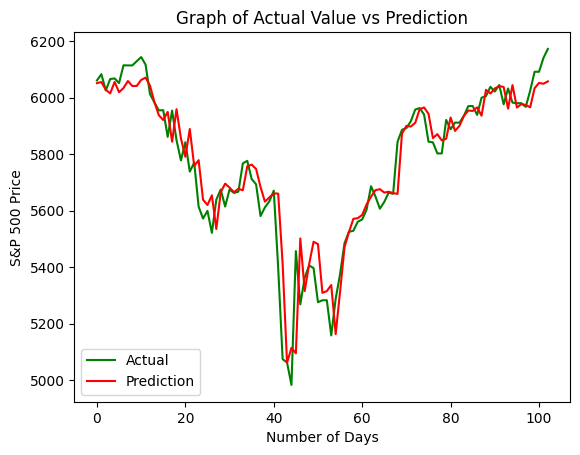

In [79]:
plt.plot(y_test.values, label="Actual", color='green')
plt.plot(y_pred, label="Prediction", color='red')

plt.title("Graph of Actual Value vs Prediction")
plt.xlabel("Number of Days")
plt.ylabel("S&P 500 Price")

plt.legend()
plt.show()

#### Model Residuals (Testing)

In [80]:
print(len(y_test))

103


In [81]:
print(len(y_pred))

103


In [82]:
residuals = np.squeeze(np.array(y_test)) - np.array(y_pred)

In [83]:
residuals_df = pd.DataFrame(residuals)

In [84]:
residuals_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       103 non-null    float64
dtypes: float64(1)
memory usage: 956.0 bytes


In [85]:
residuals_df.describe()

,0
count,103.000000
mean,-7.609805
std,88.830533
min,-338.718340
25%,-37.157754
50%,-1.511230
75%,35.928965
max,362.217871


<Axes: title={'center': 'Residual Graph of XGBoost During Testing'}>

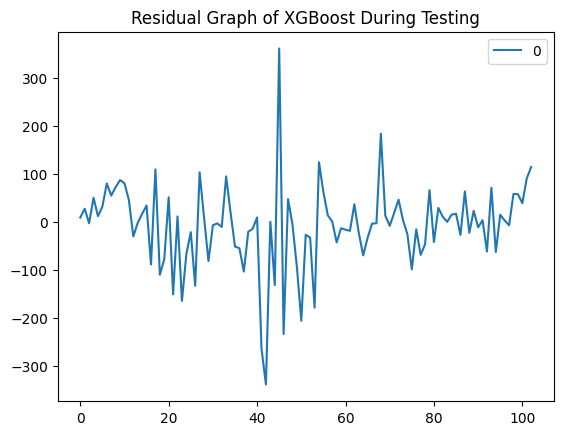

In [86]:
residuals_df.plot(title="Residual Graph of XGBoost During Testing")

<Axes: title={'center': 'Residual Density Graph'}, ylabel='Density'>

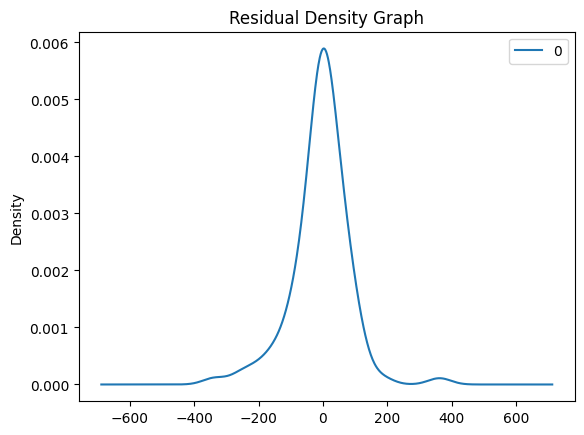

In [87]:
residuals_df.plot(kind='kde', title="Residual Density Graph")

## 6. Graph of Combined Results

#### Calculate ARIMA and GRU Prediction Values

In [88]:
"""
y_train list --> 
 - Col 0: SP500
 - Col 1: ARIMA Error
 - Col 2: GRU Error

Eliminate first row of data due to missing first row prediction after combining via XGBoost

Prediction Error = Actual - Prediction
Prediction = Actual - Prediction Error 

If prediction errors are prediction based on today (2/12/2025),
then y_true are actual value on tomorrow (3/12/2025)

To adjust for it, just slice first prediction which is 2/12/2025
Then slice the last y_true to adjust for prediction length
"""

gru_pred_lst = np.array(X_xgb['SP500']) - np.array(X_xgb['GRU Error'])
arima_pred_lst = np.array(X_xgb['SP500']) - np.array(X_xgb['ARIMA Error'])

gru_pred_lst = gru_pred_lst[1:]
arima_pred_lst = arima_pred_lst[1:]

In [89]:
print(f"Length of GRU prediction: {len(gru_pred_lst)}\n")

print(gru_pred_lst[:5])

Length of GRU prediction: 341

[5111.68261719 5153.36474609 5113.00488281 5119.80078125 5172.71240234]


In [90]:
print(f"Length of ARIMA prediction: {len(arima_pred_lst)}\n")

print(arima_pred_lst[:5])

Length of ARIMA prediction: 341

[5102.14594633 5152.12490539 5127.05842801 5118.51433275 5169.536735  ]


#### Conversion of Variables

In [91]:
print(y_xgb[:5])

observation_date
2024-03-06    5157.36
2024-03-07    5123.69
2024-03-08    5117.94
2024-03-11    5175.27
2024-03-12    5165.31
Name: SP500, dtype: float64


In [92]:
new_y_test = y_xgb.values

# Adjust for prediction length
new_y_test = new_y_test[:-1]

In [93]:
print(new_y_test[:5])

[5157.36 5123.69 5117.94 5175.27 5165.31]


In [94]:
print(len(new_y_test))

341


#### Comparison between R2 Score of Models

In [95]:
new_y_pred = xgb_model.predict(X_xgb)

# Match the missing last prediction length
new_y_pred = new_y_pred[:-1]

print(len(new_y_pred))

print(new_y_pred[:5])

341
[5149.6274 5128.747  5120.962  5164.8354 5168.4854]


In [96]:
r2_arima = r2_score(y_true=new_y_test,
                    y_pred=arima_pred_lst)

r2_gru = r2_score(y_true=new_y_test,
                  y_pred=gru_pred_lst)

r2_xgb = r2_score(y_true=new_y_test,
                  y_pred=new_y_pred)

In [97]:
r2_list = [r2_arima, r2_gru, r2_xgb]

r2_diff_with_xgb_list = [r2_arima-r2_xgb, r2_gru-r2_xgb, 0.0000]

r2_diff_per_list = [r2_diff_with_xgb_list[0]*100/r2_xgb,
                    r2_diff_with_xgb_list[1]*100/r2_xgb,
                    0.0000]

In [98]:
r2_table_dict = {
    'Model': ['ARIMA', 'GRU', 'XGB(ARIMA + GRU)'],
    'R2 Score': r2_list,
    'R2 Difference with XGB': r2_diff_with_xgb_list,
    'R2 Difference with XGB (Percentage)': r2_diff_per_list
}

r2_table_df = pd.DataFrame(r2_table_dict)

In [99]:
r2_table_df.style

,Model,R2 Score,R2 Difference with XGB,R2 Difference with XGB (Percentage)
0,ARIMA,0.962883,-0.013261,-1.358496
1,GRU,0.949936,-0.026208,-2.684849
2,XGB(ARIMA + GRU),0.976144,0.000000,0.000000


#### Plotting Actual vs Prediction of XGBoost Only

In [ ]:
# Max num days of data = 341

num_points_to_see = 200

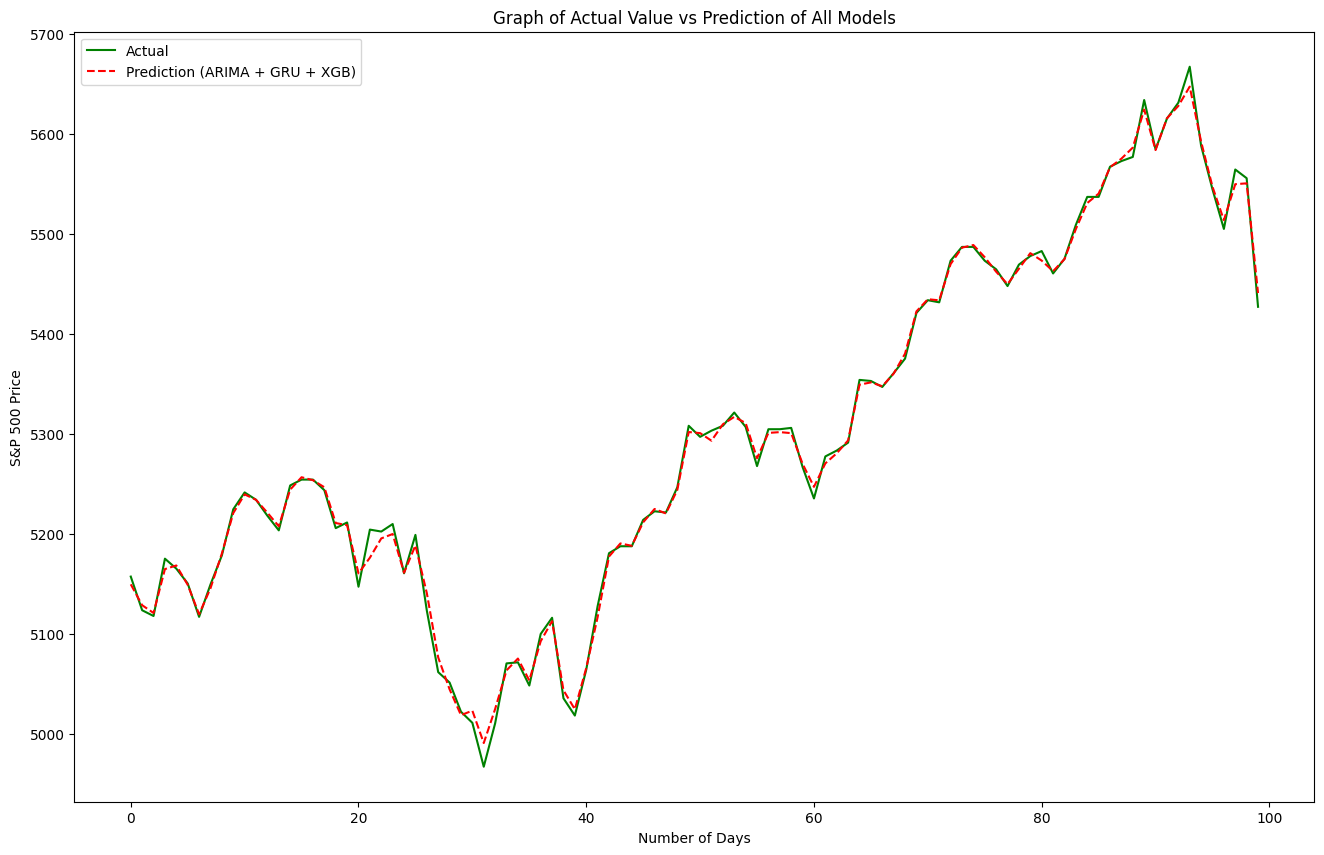

In [101]:
fig = plt.figure(figsize=(16, 10))

plt.plot(new_y_test[:num_points_to_see], label="Actual", color='green')
plt.plot(new_y_pred[:num_points_to_see], label="Prediction (ARIMA + GRU + XGB)", linestyle='dashed', color='red')

plt.title("Graph of Actual Value vs Prediction of All Models")
plt.xlabel("Number of Days")
plt.ylabel("S&P 500 Price")

plt.legend()
plt.show()

#### Plotting Actual vs Prediction of ARIMA and GRU

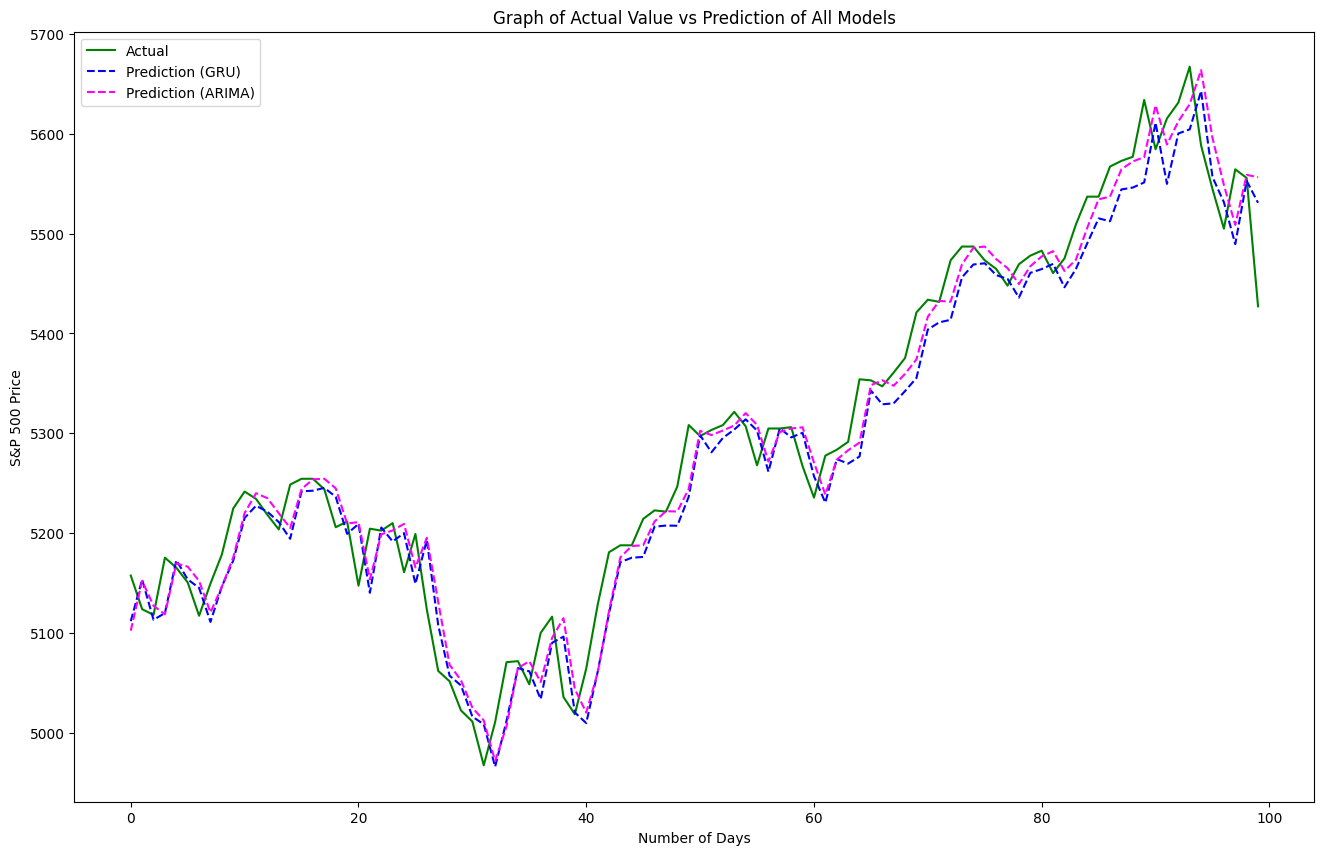

In [102]:
fig = plt.figure(figsize=(16, 10))

plt.plot(new_y_test[:num_points_to_see], label="Actual", color='green')

plt.plot(gru_pred_lst[:num_points_to_see], label="Prediction (GRU)", linestyle='dashed', color='blue')
plt.plot(arima_pred_lst[:num_points_to_see], label="Prediction (ARIMA)", linestyle='dashed', color='magenta')

plt.title("Graph of Actual Value vs Prediction of All Models")
plt.xlabel("Number of Days")
plt.ylabel("S&P 500 Price")

plt.legend()
plt.show()

#### Plotting Actual vs Prediction of All Models

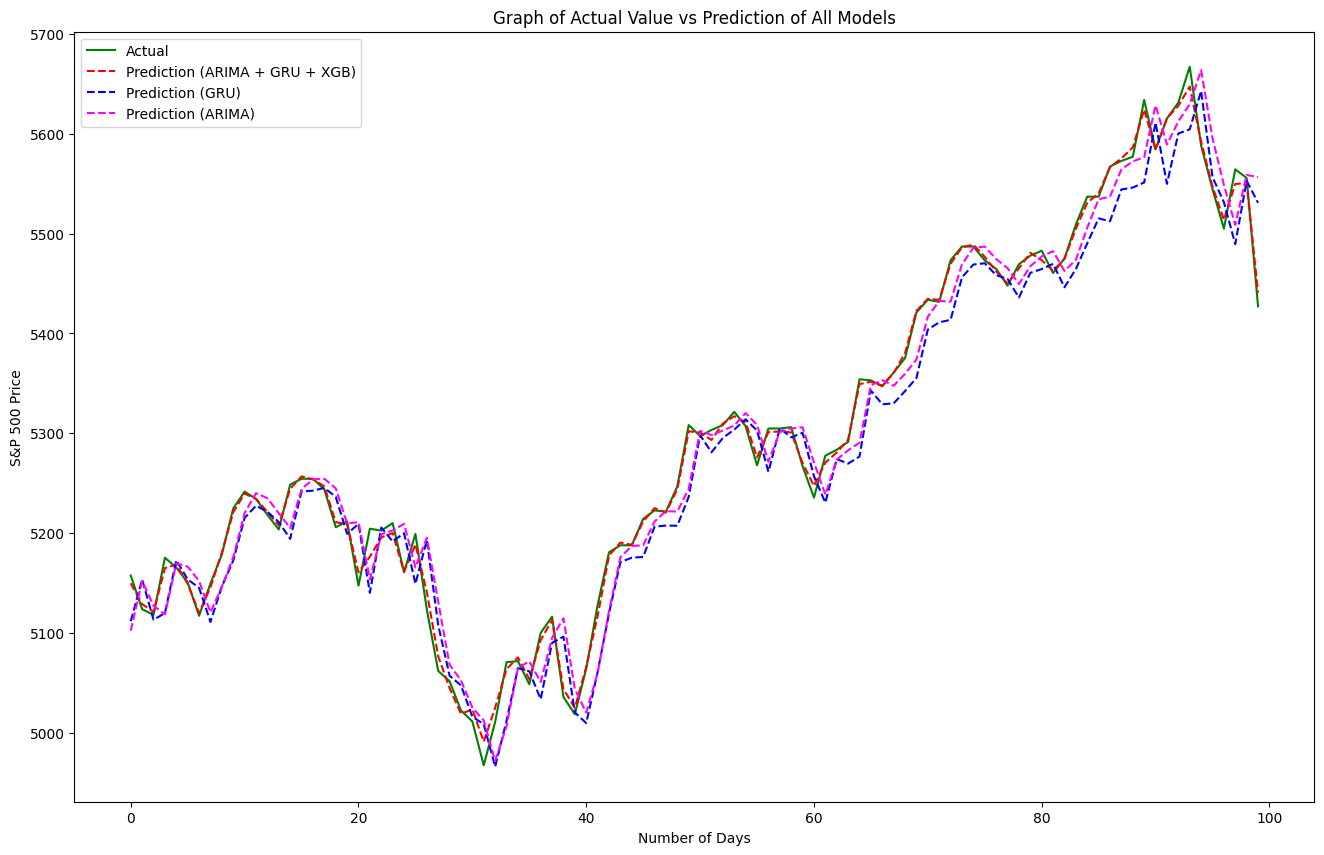

In [103]:
fig = plt.figure(figsize=(16, 10))

plt.plot(new_y_test[:num_points_to_see], label="Actual", color='green')
plt.plot(new_y_pred[:num_points_to_see], label="Prediction (ARIMA + GRU + XGB)", linestyle='dashed', color='red')

plt.plot(gru_pred_lst[:num_points_to_see], label="Prediction (GRU)", linestyle='dashed', color='blue')
plt.plot(arima_pred_lst[:num_points_to_see], label="Prediction (ARIMA)", linestyle='dashed', color='magenta')

plt.title("Graph of Actual Value vs Prediction of All Models")
plt.xlabel("Number of Days")
plt.ylabel("S&P 500 Price")

plt.legend()
plt.show()

## 7. Clark-West Test

In [104]:
def clark_west_test(y_true, y_pred_base, y_pred_hybrid):
    """
    y_true: Actual values
    y_pred_base: Predictions from your Baseline (Stage 1)
    y_pred_hybrid: Combined predictions (Stage 1 + Stage 2 Residual model)
    """
    # 1. Calculate the errors
    e_base = y_true - y_pred_base
    e_hybrid = y_true - y_pred_hybrid
    
    # 2. The Clark-West Adjustment term
    # This represents the "noise" the hybrid model adds by being complex
    adj_term = (y_pred_base - y_pred_hybrid)**2
    
    # 3. Calculate the MSPE Adjusted series
    # f_t = error_base^2 - (error_hybrid^2 - adj_term)
    f_t = e_base**2 - (e_hybrid**2 - adj_term)
    
    # 4. Perform a one-sided t-test (we want to know if Hybrid is BETTER)
    # The null hypothesis is that mean(f_t) <= 0
    t_stat = np.mean(f_t) / (np.std(f_t, ddof=1) / np.sqrt(len(f_t)))
    p_value = 1 - stats.t.cdf(t_stat, df=len(f_t)-1)
    
    return t_stat, p_value

In [105]:
# For ARIMA Model vs Hybrid

t_stat, p_val = clark_west_test(y_true=new_y_test, 
                                y_pred_base=arima_pred_lst, 
                                y_pred_hybrid=new_y_pred)

print(f"Clark-West T-Stat: {t_stat:.4f}")
print(f"P-Value: {p_val:.4f}")

if p_val < 0.05:
    print("Decision: The gain is a SIGNIFICANT signal.")
else:
    print("Decision: The gain is NOISE.")

Clark-West T-Stat: 6.3363
P-Value: 0.0000
Decision: The gain is a SIGNIFICANT signal.


In [106]:
# For GRU Model vs Hybrid

t_stat, p_val = clark_west_test(y_true=new_y_test, 
                                y_pred_base=gru_pred_lst, 
                                y_pred_hybrid=new_y_pred)

print(f"Clark-West T-Stat: {t_stat:.4f}")
print(f"P-Value: {p_val:.4f}")

if p_val < 0.05:
    print("Decision: The gain is a SIGNIFICANT signal.")
else:
    print("Decision: The gain is NOISE.")

Clark-West T-Stat: 10.6407
P-Value: 0.0000
Decision: The gain is a SIGNIFICANT signal.
